In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
%matplotlib inline
import urllib
from urllib.request import urlopen
from bs4 import BeautifulSoup
from matplotlib import cm
import emoji
import warnings
warnings.filterwarnings('ignore')

In [2]:
import nltk
nltk.download('stopwords')
import re
import io
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk import punkt
nltk.download('punkt')
import json
from nltk.stem import WordNetLemmatizer
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/superpooh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/superpooh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# step 0 - read in data file

In [3]:
df1 = pd.read_csv('animals_comments.csv')

In [4]:
df1.dropna(inplace=True)
df1.drop_duplicates(inplace=True)

In [5]:
def extract_emojis(str):
    return ''.join(c for c in str if c in emoji.UNICODE_EMOJI)
 
df1['emoji'] = df1['comment'].apply(extract_emojis)

In [6]:
print("number of comments: '%.2E', number of unique users: '%.2E', " % (df1.shape[0], df1['userid'].nunique()))

number of comments: '5.73E+06', number of unique users: '2.52E+06', 


# step 1 - label cat and dog owners:

In [7]:
# select dog owners by key words
mydog = df1[df1['comment'].str.contains("my dog|our dog|I have a dog")]
mydog.info()
# other minor selectors: mine dog|my 🐶|our 🐶|my 🐕|our 🐕|my🐶|our🐶|my🐕|our🐕

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38000 entries, 42 to 5819412
Data columns (total 4 columns):
creator_name    38000 non-null object
userid          38000 non-null int64
comment         38000 non-null object
emoji           38000 non-null object
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


In [8]:
# select cat owners by key words
mycat = df1[df1['comment'].str.contains("my cat |our cat |I have a cat |my cats |our cats |my kitty |my kitten |our kitty |our kitten ")]
mycat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18933 entries, 85 to 5818250
Data columns (total 4 columns):
creator_name    18933 non-null object
userid          18933 non-null int64
comment         18933 non-null object
emoji           18933 non-null object
dtypes: int64(1), object(3)
memory usage: 739.6+ KB


In [9]:
owndog = mydog['userid'].unique()
owncat = mycat['userid'].unique()
print("in the labeled data set :"+'\n')
print("number of comments by dog owners:",mydog.shape[0],"  number of comments by cat owners:",mycat.shape[0],'\n')
print("number of dog owners:",len(owndog),"  number of cat owners:",len(owncat))

in the labeled data set :

number of comments by dog owners: 38000   number of comments by cat owners: 18933 

number of dog owners: 33744   number of cat owners: 16514


In [10]:
# remove non-English charaters in comments

def remove_non_ascii(text):
    return ''.join(i for i in text if ord(i)<128)

mydog['comment'] = mydog['comment'].apply(remove_non_ascii)
mycat['comment'] = mycat['comment'].apply(remove_non_ascii)

In [11]:
# function for text cleaning / pre-processing

def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"\\n", "")
    df[text_field] = df[text_field].str.replace(r"\\n\\n", "")
    df[text_field] = df[text_field].str.replace(r"[", "")
    df[text_field] = df[text_field].str.replace(r"\']", "")
    df[text_field] = df[text_field].str.replace(r"\\\',", "")
    df[text_field] = df[text_field].str.replace(r"\'\"\\\'", "")
    df[text_field] = df[text_field].str.replace(r"\'\\\'\"", " ")
    df[text_field] = df[text_field].str.replace(r"\"\",", "")
    df[text_field] = df[text_field].str.replace(r"\'\\\'\"", "")
    df[text_field] = df[text_field].str.replace(r"\\", " ")
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.replace(r"\"", "")
    df[text_field] = df[text_field].str.replace(r"[0-9]", "")
    df[text_field] = df[text_field].str.replace(r"\'", "")
    df[text_field] = df[text_field].str.replace(r"\,\ \"", "")
    df[text_field] = df[text_field].str.replace("\"", "")
    df[text_field] = df[text_field].str.replace(r",", "")
    df[text_field] = df[text_field].str.replace(r"?", "")
    df[text_field] = df[text_field].str.replace(r"(", "")
    df[text_field] = df[text_field].str.replace(r")", "")         
    df[text_field] = df[text_field].str.replace(r"!", "")         
    df[text_field] = df[text_field].str.lower()
    return df

# text cleaning for labeled commments
mydog = standardize_text(mydog, 'comment')
mycat = standardize_text(mycat, 'comment')

In [12]:
# lemmatize labeled comments

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w,'v') for w in w_tokenizer.tokenize(text)]

mydog['comment'] = mydog['comment'].apply(lemmatize_text)
mycat['comment'] = mycat['comment'].apply(lemmatize_text)

In [13]:
mydog.head(5)

,creator_name,userid,comment,emoji
42,Viktor Larkhill,10269,"[hey, victor, you, be, wonderful, human, be, h...",
96,Gone to the Snow Dogs,13796,"[man, your, dog, have, the, worst, luck, hopef...",
152,The Dodo,24401,"[now, i, want, to, try, that, with, my, dog]",
281,BarkBox,41679,"[well, never, stop, get, barkbox, for, our, do...",
404,Zak Georges Dog Training rEvolution,63541,"[my, dog, lucky, wont, eat, of, his, bowl, hel...",


In [14]:
# apply label to comments: 
# dog owner = 1, cat owner = 0

mydog['kind'] = 1
mycat['kind'] = 0

In [15]:
mycat['comment'] = mycat['comment'].apply(' '.join)
mydog['comment'] = mydog['comment'].apply(' '.join)

In [16]:
# combine labeled data into 1 dataset
# data size of class 1 is reduced to the same as class 2 to balance data

mydog_s = mydog.sample(frac=0.5,random_state=1)
mypet= pd.concat([mydog_s,mycat])
mypet.info()
mypet.reset_index(inplace=True)
mypet.drop('index',axis=1,inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37933 entries, 3965473 to 5818250
Data columns (total 5 columns):
creator_name    37933 non-null object
userid          37933 non-null int64
comment         37933 non-null object
emoji           37933 non-null object
kind            37933 non-null int64
dtypes: int64(2), object(3)
memory usage: 1.7+ MB


### labeled data size:  ~ 38,000 rows
### data size between two classes are balanced
### total data size: ~ 5.7 million rows

# step 2 - build classifier :

In [17]:
# vectorizers

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

#1. bad of words
def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

#2. TF-IDF
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

#3 bigram
def cv2(data):
    count_vectorizer = CountVectorizer(ngram_range=(2,2))
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

#4. TF-IDF bigram
def tfidf2(data):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2))

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

In [18]:
# functions for performance metrics calculation and plotting:

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1


import itertools
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=40)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=36)
    plt.yticks(tick_marks, classes, fontsize=36)
    
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=40)
    plt.xlabel('Predicted label', fontsize=40)

    return plt

def get_most_important_features(vectorizer, model, n):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes


def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    plt.figure(figsize=(15, 20))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Cat owner', fontsize=36)
    plt.yticks(y_pos, bottom_words, fontsize=36)

    plt.suptitle('Key words', fontsize=36)
    plt.xlabel('Importance', fontsize=36)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Dog owner', fontsize=36)
    plt.yticks(y_pos, top_words, fontsize=36)
    plt.suptitle(name, fontsize=36)
    plt.xlabel('Importance', fontsize=36)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

    

## classifier model 1 of 3 : bag of words + logistic regression 

In [19]:
# split training and test set 
list_corpus = mypet['comment'].tolist()
list_labels = mypet['kind'].tolist()         
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=8000, random_state=200)

In [20]:
# bag of words vectorizer
X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [21]:
# logistic regression model fitting
# regularization is reduced to nearly none since it is not necessary for improving the model
# no regularization leaves the predicted probability interpretable as confidence level without calibration

lrmodel = LogisticRegression(C=10000000.0, class_weight='balanced', solver='liblinear', 
                         multi_class='ovr', n_jobs=-1, random_state=210)

lrmodel.fit(X_train_counts, y_train)
y_predicted_counts = lrmodel.predict(X_test_counts)

In [22]:
pickle.dump(lrmodel, open("lr.txt", 'wb'))

In [23]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.977, precision = 0.977, recall = 0.977, f1 = 0.977


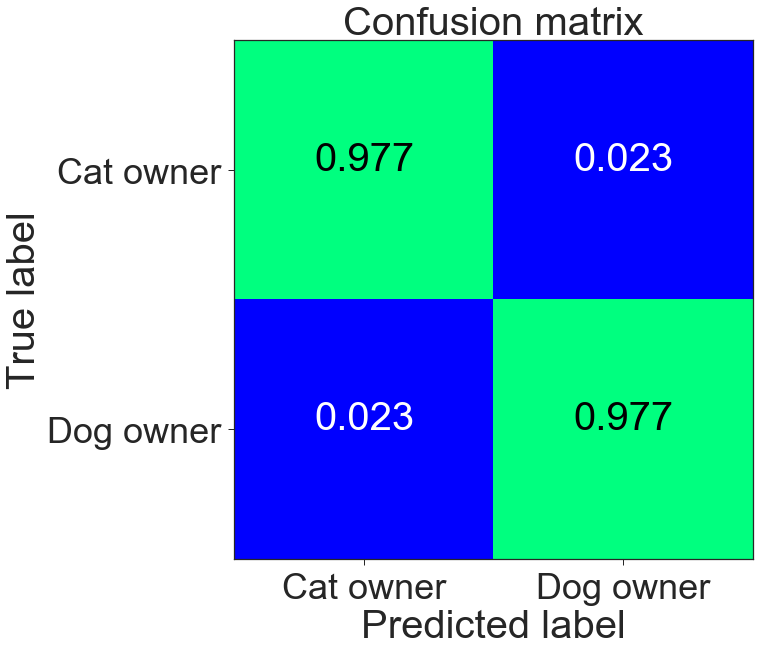

In [24]:
cm = confusion_matrix(y_test, y_predicted_counts, labels = [0,1])

plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Cat owner','Dog owner'], normalize=True, title='Confusion matrix')
plt.savefig('confusion_matr_lr_all.png')
plt.show()

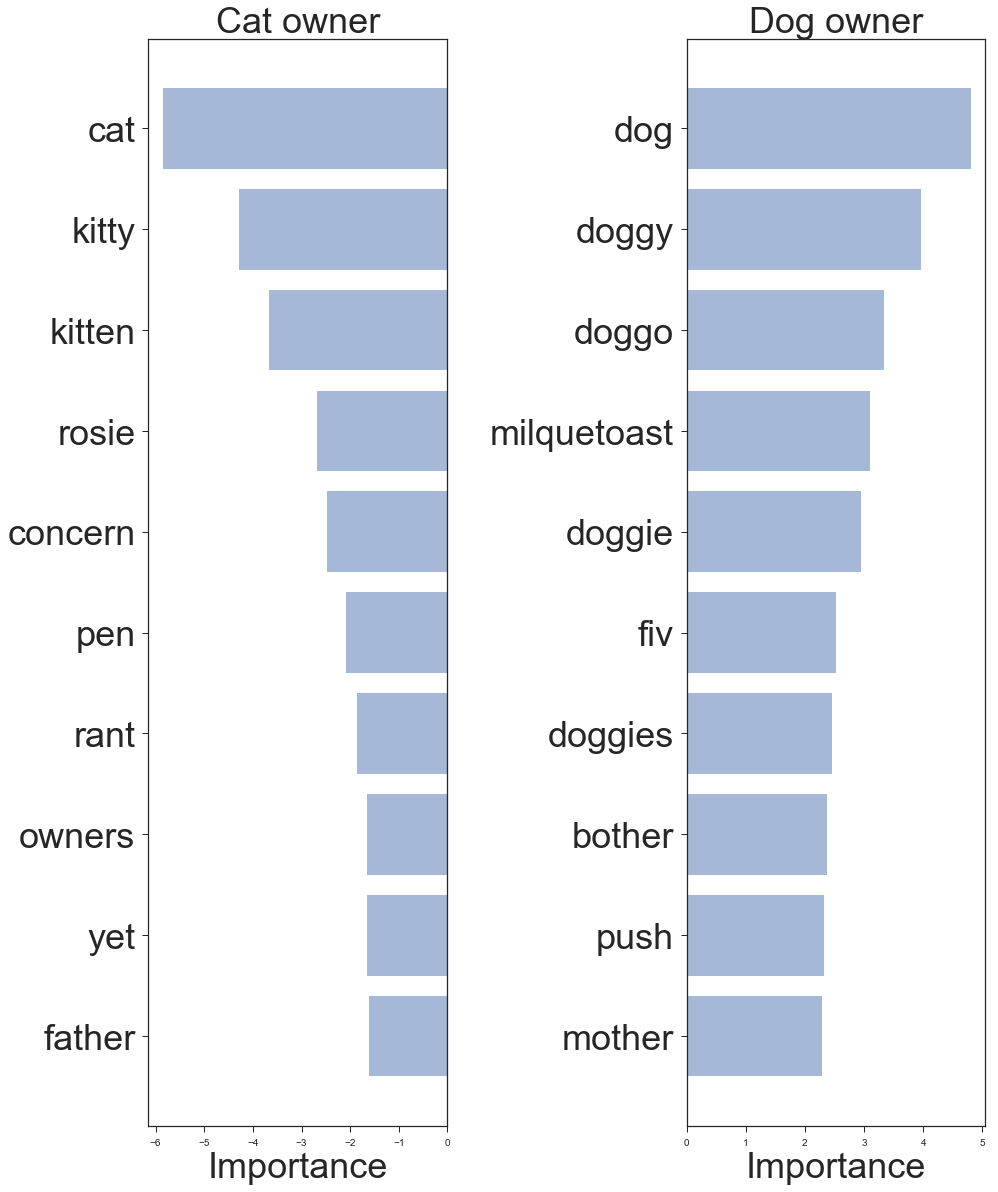

In [25]:
importance = get_most_important_features(count_vectorizer, lrmodel, 10)
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "")



## classifier model 2 of 3 : bigram + logistic regression 

In [26]:
# bigram vectorizer
X_train_counts2, count_vectorizer2 = cv2(X_train)
X_test_counts2 = count_vectorizer2.transform(X_test)

In [27]:
lrmodel2 = LogisticRegression(C=10000000.0, class_weight='balanced', solver='liblinear', 
                         multi_class='ovr', n_jobs=-1, random_state=210)

lrmodel2.fit(X_train_counts2, y_train)
y_predicted_counts2 = lrmodel2.predict(X_test_counts2)

In [28]:
pickle.dump(lrmodel2, open("lr2.txt", 'wb'))

In [29]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.977, precision = 0.977, recall = 0.977, f1 = 0.977


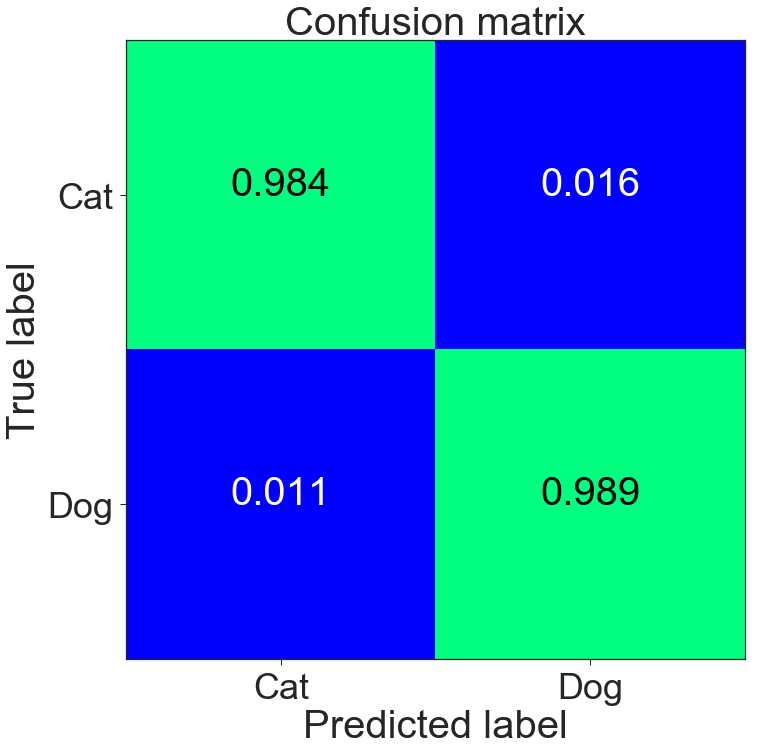

In [30]:
cm = confusion_matrix(y_test, y_predicted_counts2, labels = [0,1])

plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Cat','Dog'], normalize=True, title='Confusion matrix')
plt.savefig('confusion_matr_lr2.png')
plt.show()

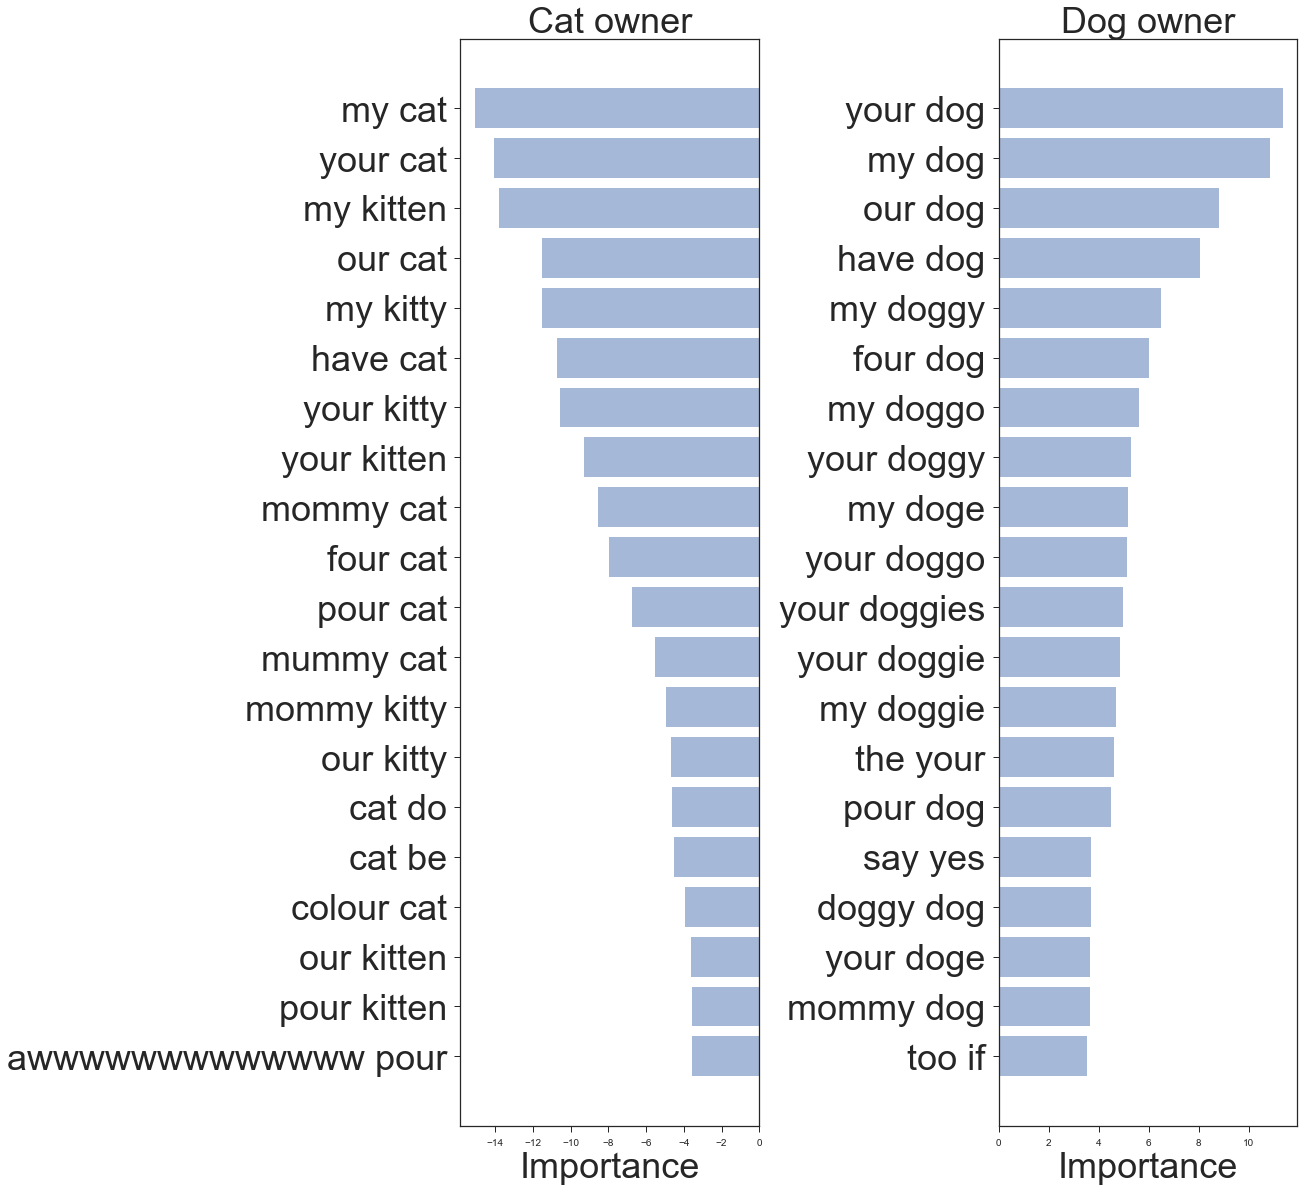

In [31]:
importance = get_most_important_features(count_vectorizer2, lrmodel2, 20)
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "")

## classifier model 3 of 3 : 1-gram tfidf + logistic regression 

In [32]:
# tfidf vectorizer
X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [33]:
# logistic regression model fitting
lrmodel_tfidf = LogisticRegression(C=1000000.0, class_weight='balanced', solver='liblinear', 
                         multi_class='ovr', n_jobs=-1, random_state=210)

lrmodel_tfidf.fit(X_train_tfidf, y_train)
y_predicted_tfidf = lrmodel_tfidf.predict(X_test_tfidf)

accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.961, precision = 0.961, recall = 0.961, f1 = 0.960


In [34]:
pickle.dump(lrmodel_tfidf, open("lr-tfidf.txt", 'wb'))

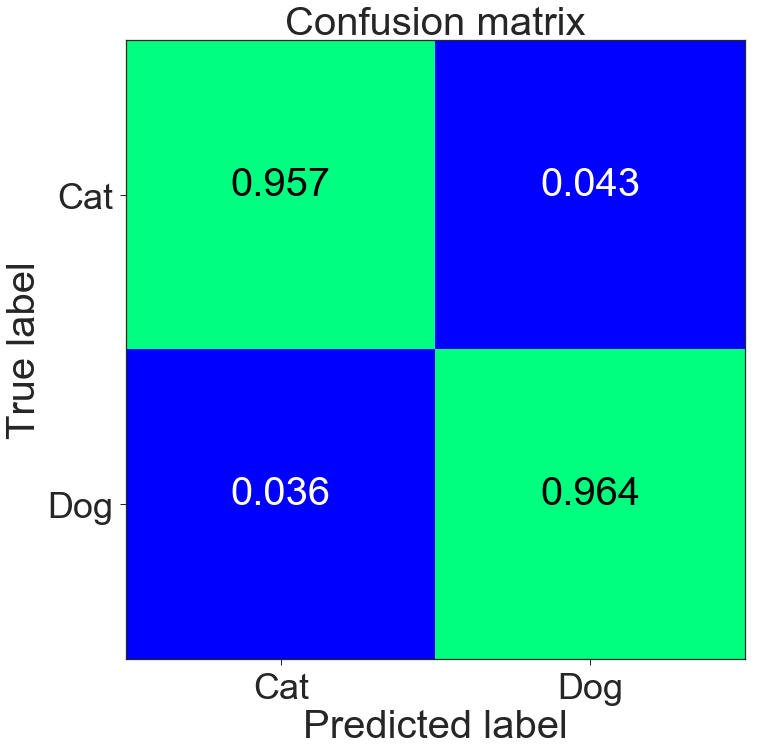

In [35]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm2, classes=['Cat','Dog'], normalize=True, title='Confusion matrix')
plt.savefig('confusion_matr_lr_tfidf_all.png')
plt.show()

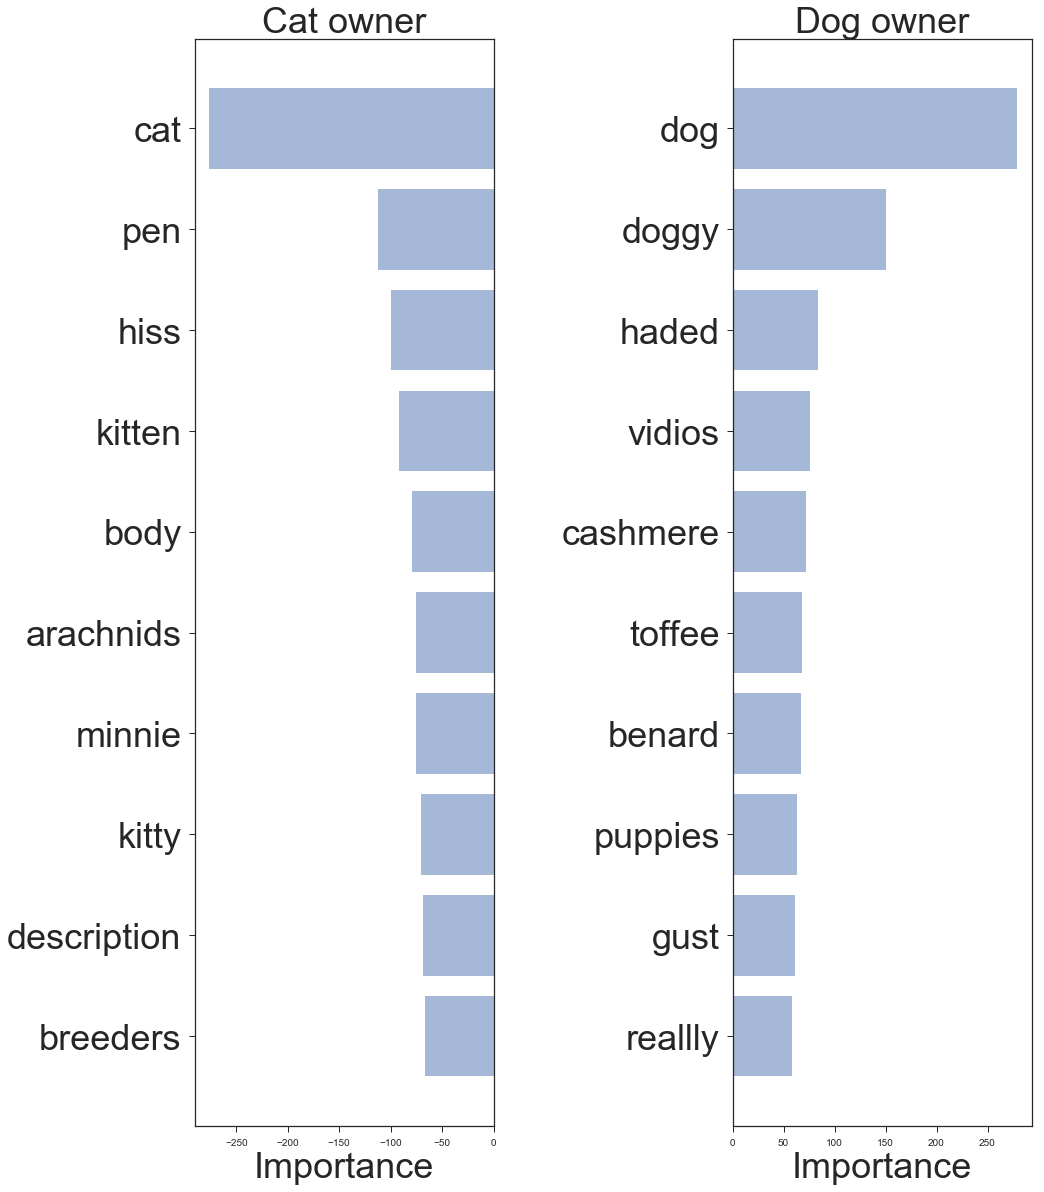

In [36]:
importance = get_most_important_features(tfidf_vectorizer, lrmodel_tfidf, 10)
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "")

## top 5 (interpretable) features of model 1:

### dog owners:
dog / doggy / doggo / doggie / doggies, milquetoast(online dog celebrity), bother, push, mother

### cat owners:
cat / kitty / kitten, rosie (online cat celebrity), concern, pen, rant

## step 2 model discussion

simpler is better

### model 1:     bag of words  +  logistic regression
judging from a combination of top feature words and model performance metrics, model 1 (bag of words logistic regression) works best.
### model 2:     bigram + logistic regression
The bigram logistic regression model gives near perfect classification accuracy but the top features seem to be an overkill. It performed badly in classifying the whole dataset by predicting the number of cat owners to be only 3% of all dog/cat owners.
However, it does reveal an interesting insight: dog/cat owners use posessive pronouns excessively. 
Excluding the features that were used to label the data, there're a fair amount of 2nd person possesive pronouns.
Dog/cat owners love to relate to other dog/cat owners!
### model 3:      1-gram tfidf +  logistic regression
The TFIDF logistic regression model performed slightly worse but still very good. The top features are less interpretable
than model 1. It could be because it dismissed some important words as stopwords (eg. possesive pronouns) 
Therefore, in the end, the bag of words model is chosen as the most suitable for analyzing the dataset,despite the fact that TFIDF classification reproduces the most ideal dog/cat owner ratio (1.5) in the following section.

# step 3: classify users in the entire dataset

## preprocess data

In [37]:
df2 = df1.copy()
df2['comment'] = df2['comment'].apply(remove_non_ascii)
df2 = standardize_text(df2, 'comment')
df2.reset_index(inplace=True)
df2.drop('index',axis=1,inplace=True)
df2.head(10)

,creator_name,userid,comment,emoji
0,Doug The Pug,87,i shared this to my friends and mom the were lol,
1,Doug The Pug,87,super cute,😀🐕🐶
2,bulletproof,530,stop saying get em youre literally dumb have...,
3,Meu Zoológico,670,tenho uma jiboia e um largato,
4,ojatro,1031,i wanna see what happened to the pigs after th...,
5,Tingle Triggers,1212,well shit now im hungry,
6,Hope For Paws - Official Rescue Channel,1806,when i saw the end it said to adopt i saw dif...,
7,Hope For Paws - Official Rescue Channel,2036,holy crap that is quite literally the most ad...,
8,Life Story,2637,,
9,Brian Barczyk,2698,call the teddy larry,


In [38]:
# data info

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5725602 entries, 0 to 5725601
Data columns (total 4 columns):
creator_name    object
userid          int64
comment         object
emoji           object
dtypes: int64(1), object(3)
memory usage: 174.7+ MB


In [39]:
# lemmatize comments

df2['comment'] = df2['comment'].apply(lemmatize_text)

In [40]:
df2['comment'] = df2['comment'].apply(' '.join)

## apply classifier model 2 (worst model) : bigram

In [41]:
# apply (training data) bigram vectorizer on the dataset

X_counts_df2 = count_vectorizer2.transform(df2['comment'])

In [42]:
# apply fitted Logistic Regression model

y_predicted_df2 = lrmodel2.predict(X_counts_df2)

In [43]:
y_predicted_proba_df2 = lrmodel2.predict_proba(X_counts_df2)

In [44]:
df2['label'] = y_predicted_df2

In [45]:
df2['proba'] = y_predicted_proba_df2[:,1]

In [46]:
labelall = df2.groupby(['userid'])['label'].agg(lambda x: x.mean())

In [47]:
labelall_proba = df2.groupby(['userid'])['proba'].agg(lambda x: x.mean())

In [48]:
# label each user as dog/cat owners using the average probability by the classifier

dogowner = labelall_proba[labelall_proba > 0.5]
catowner = labelall_proba[labelall_proba <= 0.5]

In [49]:
print ("total number of users = %.0f,  predicted dog owner = %.0f,  predicted cat owner = %.0f "% (labelall.shape[0],len(dogowner),len(catowner)))

total number of users = 2524848,  predicted dog owner = 2440856,  predicted cat owner = 83992 


In [50]:
print("predicted dog owner fraction = %.4f, predicted cat owner fraction = %.4f " % (len(dogowner)/labelall.shape[0],len(catowner)/labelall.shape[0]))

predicted dog owner fraction = 0.9667, predicted cat owner fraction = 0.0333 


## apply classifier model 1 (best model) : bag of words

In [51]:
X_counts_df2_1 = count_vectorizer.transform(df2['comment'])
y_predicted_df2_1 = lrmodel.predict(X_counts_df2_1)

In [52]:
df2['label_1'] = y_predicted_df2_1
labelall_1 = df2.groupby(['userid'])['label_1'].agg(lambda x: x.mean())

In [53]:
y_predicted_df2_1_proba = lrmodel.predict_proba(X_counts_df2_1)
df2['label_1_proba'] = y_predicted_df2_1_proba[:,1]
labelall_1_proba = df2.groupby(['userid'])['label_1_proba'].agg(lambda x: x.mean())

In [54]:
# label each user as dog/cat owners using the average probability by the classifier

dogowner_1_proba = labelall_1_proba[labelall_1_proba > 0.5]
catowner_1_proba = labelall_1_proba[labelall_1_proba <= 0.5]
print ("total number of users = %.0f,  number of predicted dog owner = %.0f,  number of predicted cat owner = %.0f "% (labelall_1_proba.shape[0],len(dogowner_1_proba),len(catowner_1_proba)))
print("predicted dog owner fraction = %.4f, predicted cat owner fraction = %.4f " % (len(dogowner_1_proba)/labelall_1_proba.shape[0],len(catowner_1_proba)/labelall_1_proba.shape[0]))

total number of users = 2524848,  number of predicted dog owner = 2096462,  number of predicted cat owner = 428386 
predicted dog owner fraction = 0.8303, predicted cat owner fraction = 0.1697 


In [75]:
# label each user as dog/cat owners using the majority votes by the classifier

dogowner_1 = labelall_1[labelall_1 > 0.5]
catowner_1 = labelall_1[labelall_1 <= 0.5]
print ("total number of users = %.0f,  number of predicted dog owner = %.0f,  number of predicted cat owner = %.0f "% (labelall_1.shape[0],len(dogowner_1),len(catowner_1)))
print("predicted dog owner fraction = %.3f, predicted cat owner fraction = %.3f " % (len(dogowner_1)/labelall_1.shape[0],len(catowner_1)/labelall_1.shape[0]))

total number of users = 2524848,  number of predicted dog owner = 2029678,  number of predicted cat owner = 495170 
predicted dog owner fraction = 0.804, predicted cat owner fraction = 0.196 


## apply classifier model 3 : 1-gram TFIDF

model 3 produced dog / cat owner ratio that is closest to general reality (1.5), but is dismissed for its less accurate performance
and less interpretable features.

In [56]:
X_tfidf_df2 = tfidf_vectorizer.transform(df2['comment'])

In [57]:
y_predicted_df2_tfidf = lrmodel_tfidf.predict(X_tfidf_df2)
df2['label_tfidf'] = y_predicted_df2_tfidf
labelall_tfidf = df2.groupby(['userid'])['label_tfidf'].agg(lambda x: x.mean())

In [58]:
# label each user as dog/cat owners using the majority votes by the classifier

dogowner_tfidf = labelall_tfidf[labelall_tfidf > 0.5]
catowner_tfidf = labelall_tfidf[labelall_tfidf <= 0.5]
print ("total number of users = %.0f,  number of predicted dog owner = %.0f,  number of predicted cat owner = %.0f "% (labelall_tfidf.shape[0],len(dogowner_tfidf),len(catowner_tfidf)))
print("predicted dog owner fraction = %.4f, predicted cat owner fraction = %.4f " % (len(dogowner_tfidf)/labelall_tfidf.shape[0],len(catowner_tfidf)/labelall_tfidf.shape[0]))

total number of users = 2524848,  number of predicted dog owner = 1409341,  number of predicted cat owner = 1115507 
predicted dog owner fraction = 0.5582, predicted cat owner fraction = 0.4418 


In [59]:
y_predicted_df2_tfidf_proba = lrmodel_tfidf.predict_proba(X_tfidf_df2)
df2['label_tfidf_proba'] = y_predicted_df2_tfidf_proba[:,1]
labelall_tfidf_proba = df2.groupby(['userid'])['label_tfidf_proba'].agg(lambda x: x.mean())

In [74]:
# label each user as dog/cat owners using the average probability by the classifier

dogowner_tfidf_proba = labelall_tfidf_proba[labelall_tfidf_proba > 0.5]
catowner_tfidf_proba = labelall_tfidf_proba[labelall_tfidf_proba <= 0.5]
print ("total number of users = %.0f,  number of predicted dog owner = %.0f,  number of predicted cat owner = %.0f "% (labelall_tfidf_proba.shape[0],len(dogowner_tfidf_proba),len(catowner_tfidf_proba)))
print("predicted dog owner fraction = %.3f, predicted cat owner fraction = %.3f " % (len(dogowner_tfidf_proba)/labelall_tfidf_proba.shape[0],len(catowner_tfidf_proba)/labelall_tfidf_proba.shape[0]))

total number of users = 2524848,  number of predicted dog owner = 1513679,  number of predicted cat owner = 1011169 
predicted dog owner fraction = 0.600, predicted cat owner fraction = 0.400 


### predicting true fraction of dog owners and cat owners:

calculation (based on model 1 result):

Label:  
positive - Dog owner  
negative - Cat owner 
    

Model 1 performance metric:  
True Positive rate - 0.977  
False Positive rate - 0.023  
True Negative rate - 0.977  
False Negative rate - 0.023  


Predicted dog owner rate  = TP + FP = 1  
Predicted cat owner rate  = TN + FN = 1  
True dog owner rate = TP + FN = 1  
True cat owner rate = TN + FP = 1  


True dog owner  = predicted dog owner - FN + FP = 2029678 - 2029678*0.023 + 495170*0.023 = 1994384  
True cat owner  = predicted cat owner - FP + FN = 495170 - 495170*0.023 + 2029678*0.023 = 530463

In [73]:
print("result:  true dog owner fraction = %.2f, true cat owner fraction = %.2f " % (1994384/labelall_tfidf.shape[0],530463/labelall_tfidf.shape[0]))

result:  true dog owner fraction = 0.79, true cat owner fraction = 0.21 


# step 5 - identify creators with large cat and dog ownership audience

model 1 bag of words classifier is used for this task.

In [63]:
# raise threshold probability for classification: 
# 0.7 <   predicted probability for dog owners  <= 1
#  0 <=  predicted probability for cat owners   < 0.3

# use bag of words logistic regression classification result

dogowner_acc = labelall_1_proba[labelall_1_proba > 0.7]
catowner_acc = labelall_1_proba[labelall_1_proba < 0.3]

In [64]:
dogowners = list(dogowner_acc.index)
catowners = list(catowner_acc.index)
df1_d = df1[df1['userid'].isin(dogowners)]
df1_c = df1[df1['userid'].isin(catowners)]
df1_d.info()
df1_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1406495 entries, 0 to 5819469
Data columns (total 4 columns):
creator_name    1406495 non-null object
userid          1406495 non-null int64
comment         1406495 non-null object
emoji           1406495 non-null object
dtypes: int64(1), object(3)
memory usage: 53.7+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 201859 entries, 6 to 5819431
Data columns (total 4 columns):
creator_name    201859 non-null object
userid          201859 non-null int64
comment         201859 non-null object
emoji           201859 non-null object
dtypes: int64(1), object(3)
memory usage: 7.7+ MB


### dog owners are more interactive than cat owners on youtube:
average comments per dog owner: 1.5, average comments per cat owner: 1.25  (summing the stats in the 3 code blocks below)

In [65]:
print("number of comments by dog owners: '%.1E', number of comments by cat owners: '%.1E', " % (df1_d.shape[0], df1_c.shape[0]))

number of comments by dog owners: '1.4E+06', number of comments by cat owners: '2.0E+05', 


In [66]:
df1_d = df1_d.drop_duplicates(subset=['creator_name','userid'],keep='first')
df1_c = df1_c.drop_duplicates(subset=['creator_name','userid'],keep='first')

In [67]:
print("summing unique dog owner audience of each creator: '%.1E', summing unique cat owner audience of each creator:: '%.1E', " % (df1_d.shape[0], df1_c.shape[0]))

summing unique dog owner audience of each creator: '9.5E+05', summing unique cat owner audience of each creator:: '1.6E+05', 


In [68]:
print('\n')
print("top 10 creators with largest dog owner audience:"+'\n')
df1_d['creator_name'].value_counts(ascending = False, normalize = True)[:10]



top 10 creators with largest dog owner audience:



Brave Wilderness                           0.200402
The Dodo                                   0.062390
Brian Barczyk                              0.049342
Taylor Nicole Dean                         0.048245
Hope For Paws - Official Rescue Channel    0.037544
Gohan The Husky                            0.034545
Vet Ranch                                  0.024566
ViralHog                                   0.021953
Gone to the Snow Dogs                      0.014893
Talking Kitty Cat                          0.012502
Name: creator_name, dtype: float64

In [69]:
print('\n')
print("top 10 creators with largest cat owner audience:"+'\n')
df1_c['creator_name'].value_counts(ascending = False, normalize = True)[:10]



top 10 creators with largest cat owner audience:



Brave Wilderness      0.163709
Robin Seplut          0.077048
Cole & Marmalade      0.048729
Taylor Nicole Dean    0.046506
The Dodo              0.046311
Talking Kitty Cat     0.039755
Vet Ranch             0.029039
stacyvlogs            0.026397
ViralHog              0.024236
Brian Barczyk         0.023265
Name: creator_name, dtype: float64

In [70]:
print('\n')
print("top 10 creators with both dog and cat owner audience:"+'\n')
df1['creator_name'].value_counts(ascending = False, normalize = True)[:10]



top 10 creators with both dog and cat owner audience:



Brave Wilderness                           0.182142
Brian Barczyk                              0.066572
The Dodo                                   0.056061
Taylor Nicole Dean                         0.040974
Hope For Paws - Official Rescue Channel    0.022166
Info Marvel                                0.020216
Robin Seplut                               0.020106
꼬부기아빠 My Pet Diary                         0.017863
Vet Ranch                                  0.017745
Gohan The Husky                            0.017299
Name: creator_name, dtype: float64